# Red neuronal para predecir poses

## Importar librerias

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from keras import layers,callbacks
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2025-07-13 22:02:55.428329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 22:02:55.435937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752465775.444905  117366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752465775.447478  117366 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752465775.454241  117366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Preparar datos

In [2]:
CARPETA=Path("../data/frames_csv")
Salida=Path("posiciones.csv")
#
# Unir los csvs para hacer uno solo
csvs = [p.resolve() for p in CARPETA.rglob("*.csv") if p.stem!=Salida]
#print(csvs)
df=pd.concat((pd.read_csv(f) for f in csvs),ignore_index=True)
df.to_csv(CARPETA/Salida, index=False, float_format="%.6f")

#print(df)

X= df.drop(columns=['label'])
Y= df['label']

poses_lb=LabelBinarizer()
Y_one_hot= poses_lb.fit_transform(Y)
#print(Y_one_hot)

## Dividir datos en:
* Entrenamiento = 70%
* Validación = 15%
* Prueba = 15%

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y_one_hot, test_size=0.30, stratify=Y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp.argmax(1), random_state=42)

## Definicion y compilacion de Red Neuronal

In [4]:
n_features = X_train.shape[1]   # 36 o 99
n_classes  = y_train.shape[1]
#print(n_features,n_classes)
#
model = Sequential([
    layers.Input( shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

I0000 00:00:1752465783.150286  117366 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4734 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Entrenamiento

In [5]:
checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=130,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=2)


Epoch 1/130


I0000 00:00:1752465786.021921  117522 service.cc:152] XLA service 0x7441cc004dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752465786.021937  117522 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-13 22:03:06.040282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752465786.139083  117522 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752465787.402229  117522 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-13 22:03:08.058735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1496', 180 bytes spill stores, 180 bytes spill loads



7/7 - 4s - 546ms/step - accuracy: 0.4597 - loss: 1.4090 - val_accuracy: 0.5442 - val_loss: 1.3032
Epoch 2/130
7/7 - 0s - 11ms/step - accuracy: 0.7417 - loss: 0.6865 - val_accuracy: 0.6160 - val_loss: 1.2439
Epoch 3/130
7/7 - 0s - 11ms/step - accuracy: 0.8318 - loss: 0.4583 - val_accuracy: 0.6243 - val_loss: 1.2023
Epoch 4/130
7/7 - 0s - 11ms/step - accuracy: 0.8928 - loss: 0.3323 - val_accuracy: 0.6354 - val_loss: 1.1846
Epoch 5/130
7/7 - 0s - 11ms/step - accuracy: 0.9159 - loss: 0.2641 - val_accuracy: 0.6519 - val_loss: 1.1678
Epoch 6/130
7/7 - 0s - 11ms/step - accuracy: 0.9461 - loss: 0.2006 - val_accuracy: 0.6961 - val_loss: 1.1476
Epoch 7/130
7/7 - 0s - 12ms/step - accuracy: 0.9502 - loss: 0.1726 - val_accuracy: 0.7293 - val_loss: 1.1221
Epoch 8/130
7/7 - 0s - 11ms/step - accuracy: 0.9603 - loss: 0.1524 - val_accuracy: 0.7762 - val_loss: 1.0892
Epoch 9/130
7/7 - 0s - 11ms/step - accuracy: 0.9733 - loss: 0.1231 - val_accuracy: 0.8343 - val_loss: 1.0478
Epoch 10/130
7/7 - 0s - 11ms/s

## Evaluación

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy en test: {test_acc:.3f}")


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
print(cm)
print(classification_report(y_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))

#Distancia cosenoidal entre los datos (Por cada clase)
#Tomar 10 frames de cada segundo

Accuracy en test: 1.000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[ 87   0   0   0]
 [  0  94   0   0]
 [  0   0 119   0]
 [  0   0   0  62]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       1.00      1.00      1.00        87
         FIRMES       1.00      1.00      1.00        94
           OTRO       1.00      1.00      1.00       119
 POSICION_FETAL       1.00      1.00      1.00        62

       accuracy                           1.00       362
      macro avg       1.00      1.00      1.00       362
   weighted avg       1.00      1.00      1.00       362



## Graficas de resultados

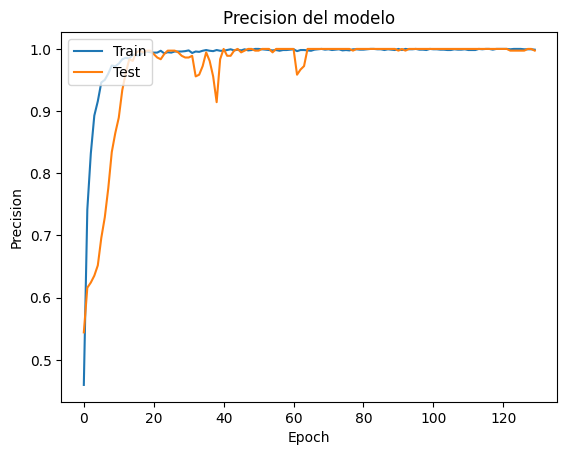

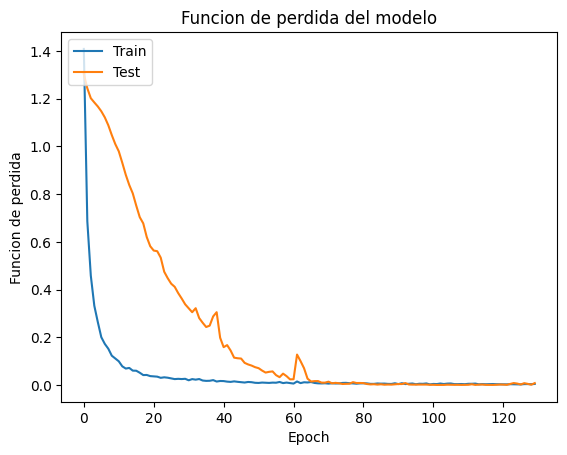

In [7]:
#Evaluar resultados
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Funcion de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida del modelo')
plt.ylabel('Funcion de perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Uso del modelo para predicción

In [ ]:
from ExtraeFrame import IMAGEN

imagen=IMAGEN("Fotos/image.png")
imagen.process(True)
x_new=imagen.extrae_frames("desconocido")
x_new=np.array([x_new])
print(len(x_new))

prediccion  = model.predict(x_new)
print (prediccion)
label  = poses_lb.inverse_transform(prediccion)
print(label)


I0000 00:00:1752465814.864677  117366 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752465814.892041  135769 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.144.03), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752465814.928492  135743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752465814.986702  135754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752465815.024543  135739 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


[0.5151408314704895, 0.12388980388641357, -0.410516619682312, 0.5371013283729553, 0.1047186627984047, -0.3877306282520294, 0.5505034923553467, 0.10574290156364441, -0.38851264119148254, 0.5636589527130127, 0.10710403323173523, -0.3885844349861145, 0.49591076374053955, 0.1035374104976654, -0.38556450605392456, 0.4818163514137268, 0.10378342866897583, -0.38649782538414, 0.4687800407409668, 0.10462590306997299, -0.38691848516464233, 0.585877537727356, 0.1164318323135376, -0.22288668155670166, 0.45612475275993347, 0.11411122232675552, -0.21174876391887665, 0.5416460633277893, 0.14955028891563416, -0.34008732438087463, 0.489414781332016, 0.14697346091270447, -0.34194865822792053, 0.6683605909347534, 0.24311676621437073, -0.17290817201137543, 0.36942413449287415, 0.23792731761932373, -0.07363874465227127, 0.719523012638092, 0.40645524859428406, -0.11123038083314896, 0.31252771615982056, 0.3818463087081909, -0.09619522839784622, 0.7392994165420532, 0.5513121485710144, -0.16479921340942383, 0.

TypeError: MpPose.extrae_valores() missing 1 required positional argument: 'label'